In [1]:
from cts import *
from strategies import *
from settings import *
from utils import *
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, trange
from scipy.io import mmread
import networkx as nx

In [2]:
import sys
# ignore warning for better readibility
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
ninstances = 50# number of simulations to run
horizon = 1000 # length of each simulation
n = 10 # number of arms

# Linear Reward for $m$ sets
In this example, the reward is the sum of all pulled arms and the set of actions is all the subset of arms of size $m$.

In [4]:
m = 3 # size of each action
means = np.random.uniform(size=n) # we choose means randomly for now
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0

In [5]:
print("Mean vector: ", means)
print("Covariance matrix: ")
print(cov)

Mean vector:  [0.21931973 0.12728596 0.16881215 0.67360722 0.10445016 0.72705796
 0.96593894 0.87563874 0.93653694 0.96831393]
Covariance matrix: 
[[1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.  0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1. ]]


In [6]:
# define the mab instance, the reward function, the oracle and the algo
mab = GaussianCombMAB(means, cov)
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algo = clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)

### Some examples on how these classes work.

In [7]:
print('Best action: ', oracle.action(mab.means))
print('Best possible mean reward: ', rew.reward(mab.means, oracle.action(mab.means)))

Best action:  [8 6 9]
Best possible mean reward:  2.8707897988281084


In [8]:
print('Algo subgaussian matrix:')
print(np.diag(algo.subg_var))

Algo subgaussian matrix:
[[1.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.2 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.2 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.2 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.2]]


### Simulation

In [31]:
ninstances = 50# number of simulations to run
horizon = 10000 # length of each simulation
n = 20 # number of arms
m = 4 # size of each action
c = 0.1 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
expid = 0
rew = LinearReward()
oracle = LinearFixedSizeOracle(m)
algos = [CUCB(n, oracle=oracle), 
         clipCTSGaussian(means=np.zeros(n), cov=(1+(m-1)*c)*np.eye(n), oracle=oracle)] 

In [32]:
regret = {}
for algo in algos:
    try: # load saved progress if it exists
        regret[algo.name] = np.load('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name)).tolist()
    except FileNotFoundError:
        regret[algo.name] = []

In [33]:
try:
    np.load('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.random.uniform(size=n)
    np.save('simulations/linearfixedsize/means_{}_{}.npy'.format(n, expid), means)
         
try:
    for algo in algos:
        for _ in trange(ninstances-len(regret[algo.name]), desc='Simulating for algo={}'.format(algo.name), leave=True):
            # generate new instance
            mab = GaussianCombMAB(means, cov)
            algo.reset() # reinitialize the algo
            # simulate instance
            reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
            regret[algo.name].append(reg)
        # save the simulations
        np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/linearfixedsize/regret_{}_{}_{}_{}_{}_{}.npy'.format(n, horizon, m, c, expid, algo.name), regret[algo.name])
    print("Simulations uncomplete. Saved current progress.")

Simulating for algo=CUCB: 0it [00:00, ?it/s]
Simulating for algo=Clip CTS-Gaussian: 0it [00:00, ?it/s]


### Plot the mean regret

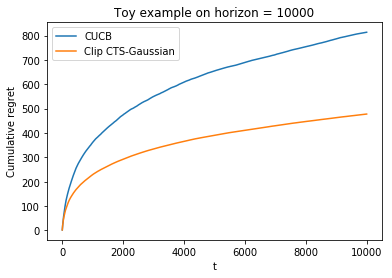

In [36]:
plt.figure()
for algo in algos:
    plt.plot(np.mean(regret[algo.name], axis=0), label=algo.name)
plt.title('Toy example on horizon = {}'.format(horizon))
plt.ylabel('Cumulative regret')
plt.xlabel('t')
plt.legend()
plt.show()

Here we took almost independent signals so this result is far from surprising.

# Shortest Path Problem

### Generate graph/MAB instance

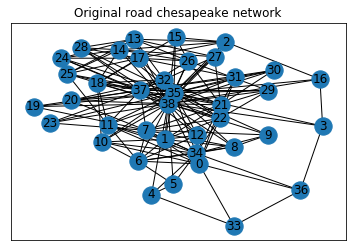

In [20]:
graph = mmread('dataset/road-chesapeake.mtx')
graph = nx.from_scipy_sparse_matrix(graph)
nx.draw_networkx(graph)
plt.title('Original road chesapeake network')
plt.show()

We won't use all the edges of the graph, but only the useful ones to link the source (1) to the target (33).

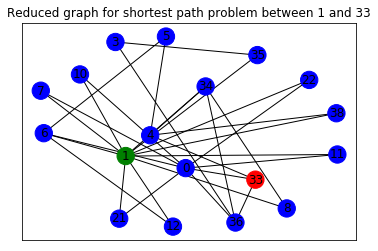

In [35]:
source = 1
target = 33
graph = potential_paths_from_source_to_target(graph, source, target)
# different colors for source and target
color_map = []
for node in graph.nodes:
    if node==source:
        color_map.append('green')
    elif node==target:
        color_map.append('red')
    else:
        color_map.append('blue')
layout = nx.spring_layout(graph, dim=2, k=20, pos={source: [-3, -3], target: [5, 1]})
nx.draw_networkx(graph, node_color=color_map, pos=layout)
plt.title('Reduced graph for shortest path problem between {} and {}'.format(source, target))
plt.show()

### Simulations

In [13]:
ninstances = 10# number of simulations to run
horizon = 10000 # length of each simulation
n = len(graph.edges)
s = n//2 # fixed sum of rewards
expid = 2
rew = PathReward(graph)
oracle = ShortestPathOracle(graph)
algos = [CUCB(n, oracle=oracle, sigma=1/2, delta=lambda t:max(1, 1.05*np.log(t))), 
         CUCBKLPath(n, oracle=oracle, precision=1e-3, max_iter=1000, delta=lambda t:max(1, 1.05*np.log(t))),
         CTSBetaPath(n, oracle=oracle)] 

In [14]:
regret = {}
for algo in algos:
    try: # load saved progress if it exists
        regret[algo.name] = np.load('simulations/shortestpath/regret_{}_{}_{}_{}.npy'.format(n, horizon, expid, algo.name)).tolist()
    except FileNotFoundError:
        regret[algo.name] = []

In [15]:
try:
    means = np.load('simulations/shortestpath/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.maximum(np.random.normal(1/2, 1/4, size=n), 0)
    np.save('simulations/shortestpath/means_{}_{}.npy'.format(n, expid), means)
       
for i, (u,v) in enumerate(graph.edges): # generate random weights on edges
    graph[u][v]['weight'] = means[i]
mab = BinaryCondSumMAB(means, s=s)
    
try:
    for algo in algos:
        for _ in trange(ninstances-len(regret[algo.name]), desc='Simulating for algo: {}'.format(algo.name), leave=True):
            # generate new instance
            algo.reset() # reinitialize the algo
            # simulate instance
            reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
            regret[algo.name].append(reg)
        # save the simulations
        np.save('simulations/shortestpath/regret_{}_{}_{}_{}.npy'.format(n, horizon, expid, algo.name), regret[algo.name])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/shortestpath/regret_{}_{}_{}_{}.npy'.format(n, horizon, expid, algo.name), regret[algo.name])
    print("Simulations uncomplete. Saved current progress.")

Simulating for algo: CUCB: 0it [00:00, ?it/s]
Simulating for algo: CUCB-KL: 0it [00:00, ?it/s]
Simulating for algo: Optimistic CTS-Beta: 0it [00:00, ?it/s]


### Visualisation

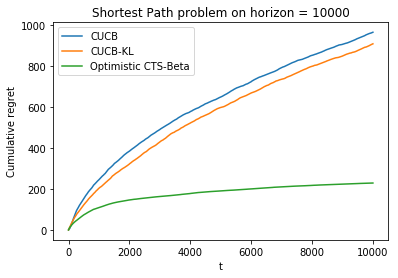

In [16]:
plt.figure()
for algo in algos:
    plt.plot(np.mean(regret[algo.name], axis=0), label=algo.name)
plt.title('Shortest Path problem on horizon = {}'.format(horizon))
plt.ylabel('Cumulative regret')
plt.xlabel('t')
plt.legend()
plt.show()

Here CUCB and CUCB-KL are pretty similar because the means of the arms are all close to 1/2. (maybe we could relax this ?)

# Maximum matching

### Generate instance

We here consider a complete bipartite graph (5,5).

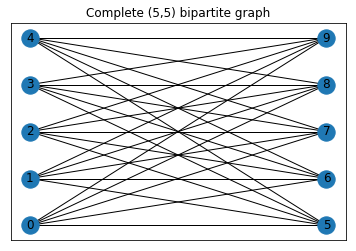

In [9]:
graph = nx.complete_bipartite_graph(5, 5)
left, right = nx.bipartite.sets(graph)
nx.draw_networkx(graph, pos = nx.drawing.layout.bipartite_layout(graph, left))
plt.title('Complete (5,5) bipartite graph')
plt.show()

### Simulations

In [17]:
ninstances = 10# number of simulations to run
horizon = 10000 # length of each simulation
n = len(graph.edges)
m = np.minimum(len(left), len(right))
expid = 0
c = 0.3 # term to tune our choice of covariance
cov = (1-c)*np.eye(n) + c*np.ones((n,n))
rew = MatchingReward(graph)
oracle = MaxMatchingOracle(graph)
algos = [CUCB(n, oracle=oracle, sigma=1, delta=lambda t:max(1, 1.05*np.log(t))),
         ESCBCompleteMatching(graph, cov=np.maximum(cov, 0)),
         clipCTSGaussian(np.zeros(n), cov=(1+(m-1)*np.maximum(c,0))*np.eye(n), oracle=oracle)] 

In [18]:
regret = {}
for algo in algos:
    try: # load saved progress if it exists
        regret[algo.name] = np.load('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name)).tolist()
    except FileNotFoundError:
        regret[algo.name] = []

In [19]:
try:
    means = np.load('simulations/maxmatching/means_{}_{}.npy'.format(n, expid))
except FileNotFoundError:
    means = np.random.uniform(0, 1, size=n)
    np.save('simulations/maxmatching/means_{}_{}.npy'.format(n, expid), means)
       
for i, (u,v) in enumerate(graph.edges): # generate random weights on edges
    graph[u][v]['weight'] = means[i]
mab = GaussianCombMAB(means, cov)
    
try:
    for algo in algos:
        for _ in trange(ninstances-len(regret[algo.name]), desc='Simulating for algo: {}'.format(algo.name), leave=True):
            # generate new instance
            algo.reset() # reinitialize the algo
            # simulate instance
            reg, _ = simu(mab, rew, oracle, algo, horizon) # the second argument is the history of pulls
            regret[algo.name].append(reg)
        # save the simulations
        np.save('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name), regret[algo.name])
    
except KeyboardInterrupt: # save progress in case of Keyboard interrupt (happens for long simulations)
    np.save('simulations/maxmatching/regret_{}_{}_{}_{}_{}.npy'.format(n, horizon, c, expid, algo.name), regret[algo.name])
    print("Simulations uncomplete. Saved current progress.")


Simulating for algo: CUCB: 100%|██████████| 20/20 [04:58<00:00, 15.62s/it]

Simulating for algo: ESCB: 100%|██████████| 29/29 [55:58<00:00, 113.47s/it]

Simulating for algo: Clip CTS-Gaussian: 100%|██████████| 30/30 [06:52<00:00, 14.14s/it]


### Visualisation

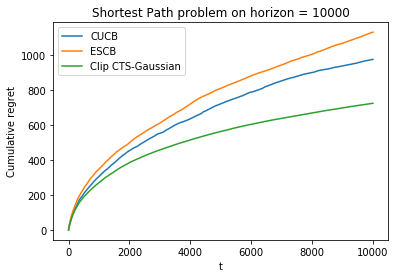

In [21]:
plt.figure()
for algo in algos:
    plt.plot(np.mean(regret[algo.name], axis=0), label=algo.name)
plt.title('Shortest Path problem on horizon = {}'.format(horizon))
plt.ylabel('Cumulative regret')
plt.xlabel('t')
plt.legend()
plt.show()